In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read data

In [2]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [3]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    # 'Month',
    # 'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    # 'SO2',
    'temp_max',
    'temp_min',
    # 'temp_mean',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [4]:
# add lag
# df_final['SO2_lag1'] = df_final['SO2'].shift(1)
# df_final['SO2_lag2'] = df_final['SO2'].shift(2)
# df_final['SO2_lag3'] = df_final['SO2'].shift(3)

# df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
# df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [5]:
df_final = df_final.dropna()

In [6]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1823 entries, 3 to 1825
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1823 non-null   object 
 1   DayOfWeekNum   1823 non-null   int64  
 2   WeekOfYear     1823 non-null   int64  
 3   IsHoliday      1823 non-null   int64  
 4   NUMBER_INT     1823 non-null   int64  
 5   temp_max       1823 non-null   float64
 6   temp_min       1823 non-null   float64
 7   humidity_max   1823 non-null   float64
 8   temp_min_lag3  1823 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 142.4+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1823,1823,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1823.0,NaN,NaN,NaN,2.998903,2.00192,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1823.0,NaN,NaN,NaN,26.657707,15.041553,1.0,14.0,27.0,40.0,53.0
IsHoliday,1823.0,NaN,NaN,NaN,0.024136,0.153514,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1823.0,NaN,NaN,NaN,47.806363,15.627747,11.0,37.0,47.0,59.0,94.0
temp_max,1823.0,NaN,NaN,NaN,28.306089,3.039403,17.8,26.3,28.5,30.4,37.7
temp_min,1823.0,NaN,NaN,NaN,17.786725,2.625516,7.3,16.1,18.4,19.7,24.1
humidity_max,1823.0,NaN,NaN,NaN,82.257817,9.232062,42.0,77.0,84.0,90.0,94.0
temp_min_lag3,1823.0,NaN,NaN,NaN,17.790071,2.627804,7.3,16.1,18.4,19.7,24.1


In [7]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
IsHoliday          int64
NUMBER_INT         int64
temp_max         float64
temp_min         float64
humidity_max     float64
temp_min_lag3    float64
dtype: object

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [9]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [10]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final = df_final.sort_values(by='Date')

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)

df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [11]:
df_train.head()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
3,6,1,0,20,30.6,22.2,81.0,20.6
4,0,2,0,51,30.8,20.8,79.0,21.0
5,1,2,0,23,29.5,20.5,79.0,20.2
6,2,2,0,43,28.0,19.9,78.0,22.2
7,3,2,0,49,30.4,19.7,74.0,20.8


In [12]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1456,3,52,0,60,24.8,18.8,92.0,18.5
1457,4,52,0,61,25.4,18.5,92.0,18.5
1458,5,52,0,30,27.5,17.7,92.0,18.6
1459,6,52,0,26,27.3,18.5,93.0,18.8
1460,0,1,0,61,25.9,19.2,92.0,18.5


In [13]:
df_val.head()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1461,1,1,1,44,27.9,19.2,92.0,17.7
1462,2,1,0,45,31.1,18.9,90.0,18.5
1463,3,1,0,28,30.7,20.4,88.0,19.2
1464,4,1,0,37,25.4,19.0,91.0,19.2
1465,5,1,0,36,30.1,18.6,91.0,18.9


In [14]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1821,4,52,0,48,29.1,19.9,83.0,17.6
1822,5,52,0,39,28.6,19.7,88.0,17.4
1823,6,52,0,36,29.4,18.8,90.0,20.8
1824,0,1,0,41,29.3,18.1,84.0,19.9
1825,1,1,0,49,29.9,18.8,79.0,19.7


## Test (10x with cv)

In [15]:
results = []

In [16]:
# Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}

param_grid = {
    'n_estimators': [60],
    'max_depth': [2],
    'learning_rate': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

In [17]:
for i in range(1):

    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=10),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.2f}")

    best_xgb_model = grid_search.best_estimator_

    # Only first 30 days
    X_val_30 = X_val.iloc[:30]
    y_val_30 = y_val.iloc[:30]
    y_pred = best_xgb_model.predict(X_val_30)

    # y_pred = best_xgb_model.predict(X_val)

    # Metrics
    # mse = mean_squared_error(y_val, y_pred)
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error(y_val, y_pred)
    # mape_val = mape(y_val, y_pred)
    # smape_val = smape(y_val, y_pred)
    # r2 = r2_score(y_val, y_pred)
    # corr = np.corrcoef(y_val, y_pred)[0, 1]
    mse = mean_squared_error(y_val_30, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_30, y_pred)
    mape_val = mape(y_val_30, y_pred)
    smape_val = smape(y_val_30, y_pred)
    r2 = r2_score(y_val_30, y_pred)
    corr = np.corrcoef(y_val_30, y_pred)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })



Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.56


In [18]:
# Show results
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,55.238956,7.432291,6.38601,16.528301,17.791211,0.175004,0.702045,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555116


In [19]:
## Aggregate Results
print(results_df.describe())

       run  random_state        MSE      RMSE      MAE       MAPE      sMAPE  \
count  1.0           1.0   1.000000  1.000000  1.00000   1.000000   1.000000   
mean   1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   
std    NaN           NaN        NaN       NaN      NaN        NaN        NaN   
min    1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   
25%    1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   
50%    1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   
75%    1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   
max    1.0           0.0  55.238956  7.432291  6.38601  16.528301  17.791211   

             R2  Correlation  Best Cross-validated R-squared  
count  1.000000     1.000000                        1.000000  
mean   0.175004     0.702045                        0.555116  
std         NaN          NaN                             NaN  
min    0.175004     0.70204

## Plots    

In [20]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 1 with RMSE = 7.43
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}


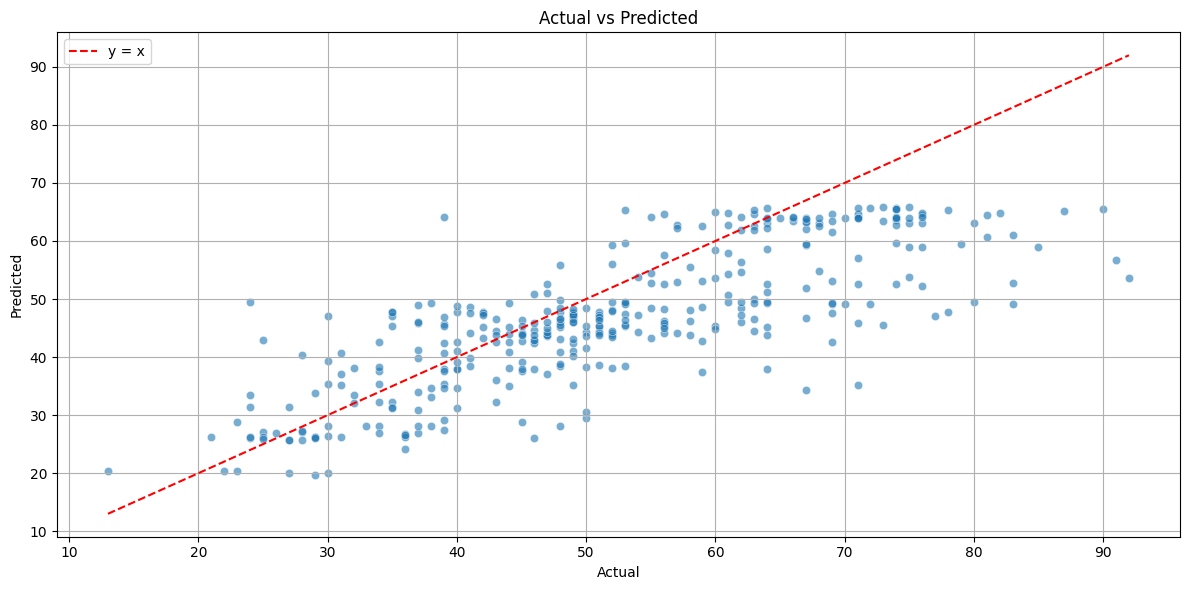

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val, y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

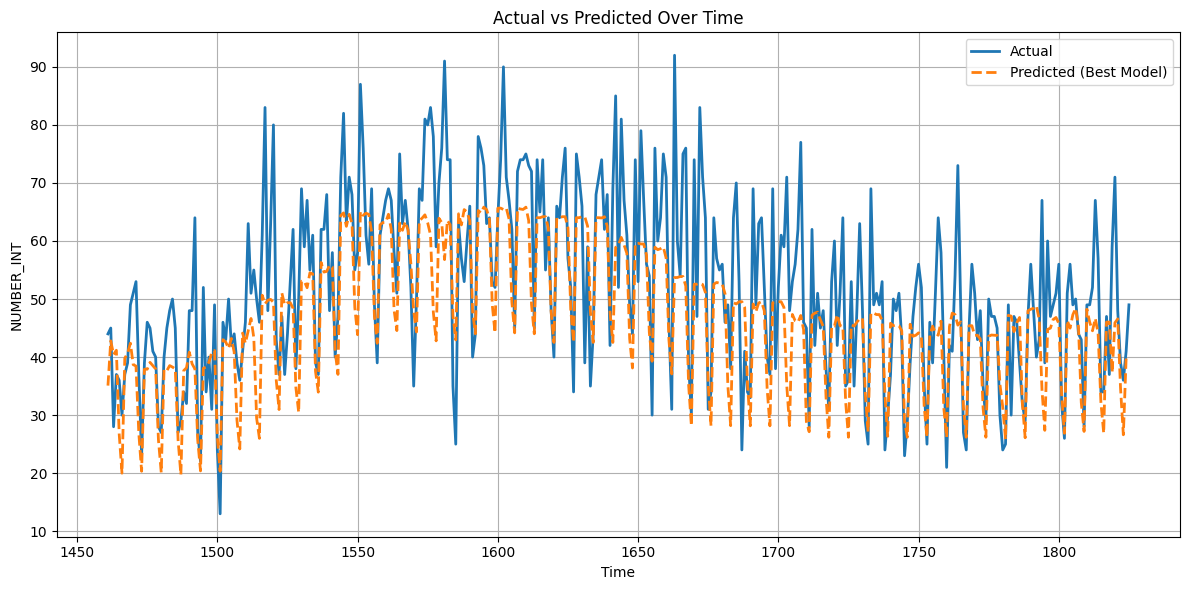

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

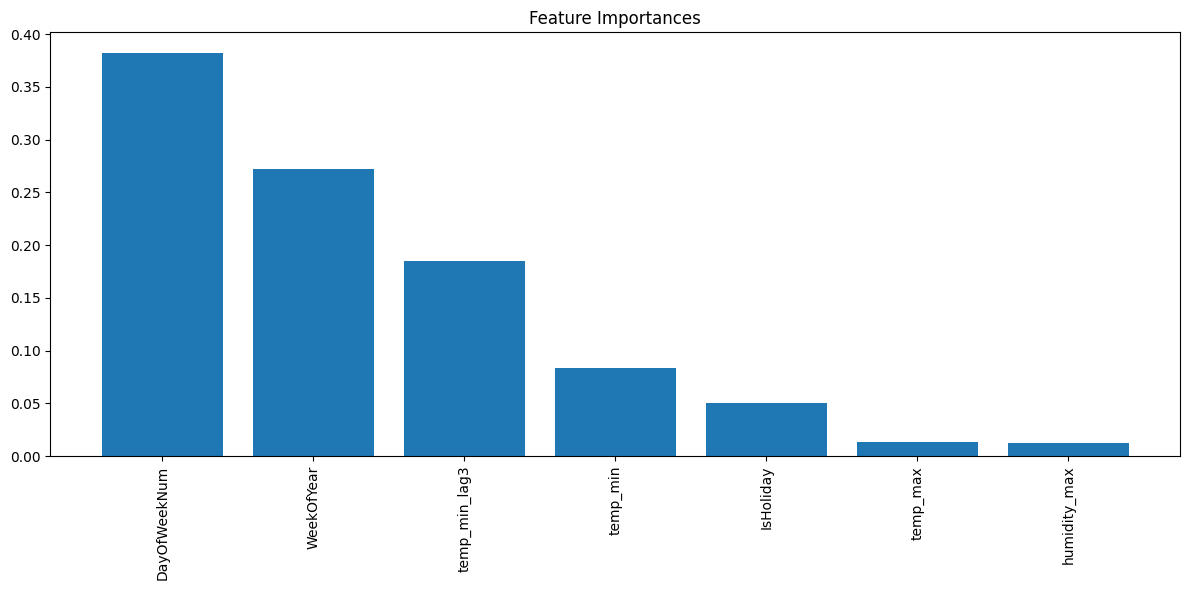

In [23]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()